# Hypothesis Testing, FDR

Now, it's time to take a look at hypothesis testing. Using posterior error probability (PEP), we answer the burning question that we have always wanted to answer in our lifetime : are Messi and Ronaldo elite at shot conversion ?

In [1]:
%load_ext autoreload
%autoreload 2
from scipy.stats import beta
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import numpy as np
import matplotlib.cm as cm

df = pd.read_csv('fbrefshootingdata.csv', encoding='utf-8-sig')
df = df[(df.npG >= 1) & (df.Shots >= 10)].reset_index(drop=True)
df['Conv'] = df['npG']/df['Shots']
bf = beta.fit(df['Conv'], floc=0, fscale=1)
df['Eb_Conv'] = (df['npG']+bf[0])/(df['Shots']+bf[0]+bf[1])

In [2]:
players = ['Lionel Messi','Robert Lewandowski','Cristiano Ronaldo','Antoine Griezmann',
           'Kylian Mbappé','Erling Haaland']
dfp = df[df['Player'].apply(lambda x: any(word in x for word in players))].reset_index(drop=True)
dfp

,Player,90s,Goals,Shots,PKs,npxG,npG,Born,Age,Conv,Eb_Conv
0,Antoine Griezmann (1991),133.3,59.0,337.0,6.0,45.8,53.0,1991.0,30.0,0.157270,0.151801
1,Cristiano Ronaldo (1985),133.5,115.0,760.0,28.0,83.8,87.0,1985.0,36.0,0.114474,0.113735
2,Erling Haaland (2000),49.5,53.0,172.0,5.0,35.7,48.0,2000.0,21.0,0.279070,0.249275
3,Kylian Mbappé (1998),110.1,100.0,456.0,9.0,87.6,91.0,1998.0,23.0,0.199561,0.192514
4,Lionel Messi (1987),138.6,126.0,748.0,14.0,81.5,112.0,1987.0,34.0,0.149733,0.147464
5,Robert Lewandowski (1988),132.1,146.0,604.0,25.0,113.2,121.0,1988.0,33.0,0.200331,0.194879


Let's say a conversion percent of 11 is the pre-requisite to get inducted into the Shot Conversion Hall of Fame. Using the posterior distribution for each player, we can see that each of them have a non-zero probability that shot conversion is less than 0.11, or 11%. Let's look at an example to clarify the point.

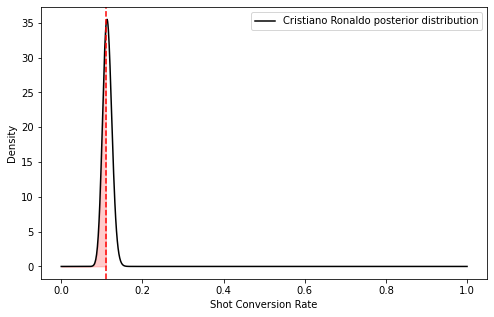

In [3]:
def player_posterior_distribution(player, ax, ls):
    dfp = df[df.Player.str.contains(player)]
    a = dfp['npG'] + bf[0]
    b = dfp['Shots'] + bf[1] - dfp['npG']
    x = np.linspace(0,1,1000)
    y = beta.pdf(x, a, b)
    ax.plot(x,y,label=player+' posterior distribution',ls=ls,color='k')
    ax.axvline(0.11, color='r',ls='--')
    xcv = np.linspace(0,0.11,100)
    ycv = beta.pdf(xcv,a,b)
    ax.fill_between(xcv,ycv,0,color='r',alpha=0.2)
    
fig,ax  = plt.subplots(figsize=(8,5))
player_posterior_distribution('Cristiano Ronaldo', ax, '-')
ax.set_xlabel('Shot Conversion Rate');
ax.set_ylabel('Density');
ax.legend();

The shaded area in the above gives the probability that Ronaldo doesn't belong to the Hall of Fame of Shot Conversion %. To calculate the area, we use the cumulative distribution function of the beta. 

In [4]:
for i, player in enumerate(dfp.Player.unique()):
    a = dfp['npG'][i] + bf[0]
    b = dfp['Shots'][i] + bf[1] - dfp['npG'][i]
    PEP = beta.cdf(0.11, a, b)
    print(f"Probability of {player} not belonging to shot conversion hall of fame is {round(PEP,2)*100} %")

Probability of Antoine Griezmann (1991) not belonging to shot conversion hall of fame is 1.0 %
Probability of Cristiano Ronaldo (1985) not belonging to shot conversion hall of fame is 38.0 %
Probability of Erling Haaland (2000) not belonging to shot conversion hall of fame is 0.0 %
Probability of Kylian Mbappé (1998) not belonging to shot conversion hall of fame is 0.0 %
Probability of Lionel Messi (1987) not belonging to shot conversion hall of fame is 0.0 %
Probability of Robert Lewandowski (1988) not belonging to shot conversion hall of fame is 0.0 %


Let's actually evaluate this for all players in the dataframe and plot out a histogram.

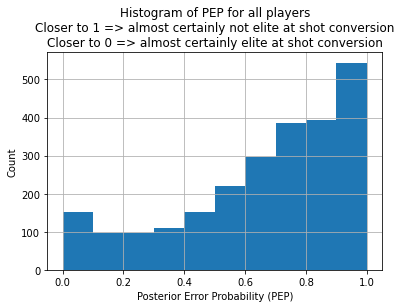

In [5]:
df['PEP'] = beta.cdf(0.11,df['npG'] + bf[0],df['Shots'] + bf[1] - df['npG'])
fig,ax  = plt.subplots(figsize=(6,4))
df['PEP'].hist()
ax.set_ylabel('Count');
ax.set_xlabel('Posterior Error Probability (PEP)');
ax.set_title('Histogram of PEP for all players'+'\n'+
            'Closer to 1 => almost certainly not elite at shot conversion'+'\n'+
            'Closer to 0 => almost certainly elite at shot conversion');

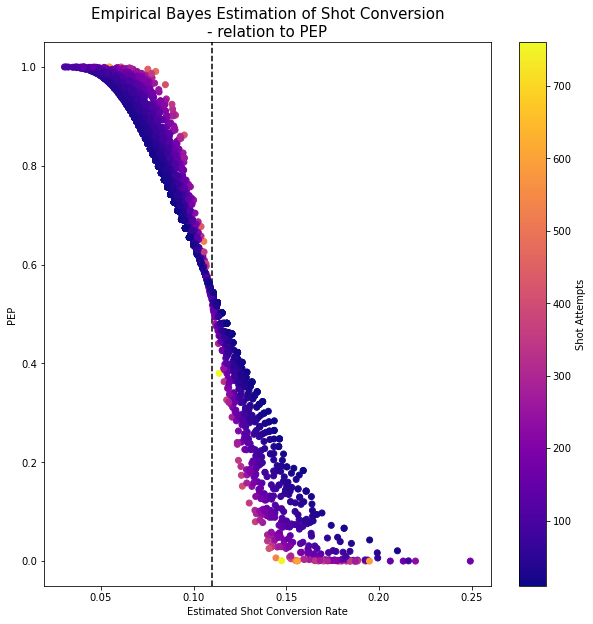

In [6]:
fig,ax  = plt.subplots(figsize = (10,10))
im = ax.scatter(df['Eb_Conv'], df['PEP'],
           c=df['Shots'],cmap=cm.plasma,zorder=10)
ax.axvline(0.11, ls='--',color='k')
# ax.set_aspect('equal')
ax.set_xlabel('Estimated Shot Conversion Rate');
ax.set_ylabel('PEP');
fig.colorbar(im, ax=ax).set_label('Shot Attempts');
ax.set_title('Empirical Bayes Estimation of Shot Conversion'+'\n'+
             '- relation to PEP', fontsize = 15);

Now we will talk about False Discovery Rate or FDR. We ask the question : how many players can be safely inducted into the Shot Conversion Hall of Fame ? By safely, we actually mean : at max only a certain % of the players inducted into the Hall of Fame would be present there erroneously. This percentage could be 5 % , ie., only about 5% of the players were included falsely. We can do this by calculating q-value, which is the mean PEP of the players included into the Hall of Fame. By doing a cumulative mean(including all players one by one incrementally), we can get a full plot of qvalue threshold and number of players included at that threshold. If our q-value threshold is small, like 5%, we can only include a few players, but if its 25%, a lot more players can be included (albeit at the cost that about 25% of those inclusions are probably erroneous).

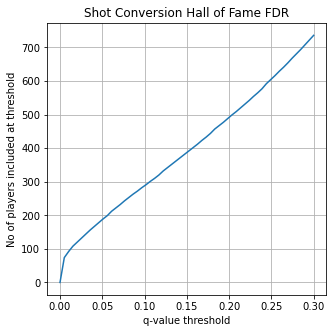

In [7]:
df.sort_values(by='PEP',inplace=True)
df.reset_index(drop=True,inplace=True)
df['qvalue'] = round(df.PEP.expanding().mean(),3)
qv = np.linspace(0,0.3,60)
numPlayers = [len(df[df.qvalue<q]) for q in qv]
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(qv, numPlayers)
ax.set_xlabel('q-value threshold')
ax.set_ylabel('No of players included at threshold')
ax.set_title('Shot Conversion Hall of Fame FDR')
ax.grid()